# Path Optimization to min Jerk 
$$ \min_{x(t)} \int_{t_0}^{t_f} \dddot x(t)^2 dt $$

In [6]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
  !wget -O basic_material.py https://www.dropbox.com/s/o48uhuwah8n2xww/basic_material.py?dl=0
%run basic_material

try:
  %reload_ext autoreload
except:
  %load_ext autoreload
%autoreload 2

try:
    from pyomo.environ import *
except:
    %pip install pyomo
from pyomo.environ import *
from pyomo.dae import *

# check if ipopt is installed. If not, install.
if not (shutil.which("ipopt") or os.path.isfile("ipopt")):
    if "google.colab" in sys.modules:
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
    else:
        try:
            !conda install -c conda-forge ipopt 
        except:
            pass
assert(shutil.which("ipopt") or os.path.isfile("ipopt"))

Running Python: 3.9.9


In [7]:
x0 = -5
xf = 5
tf = 4

In [8]:
m4 = ConcreteModel()
# define the independent variable
m4.t = ContinuousSet(bounds=(0,tf))

# define the dependent variables
m4.x = Var(m4.t)  
# define derivatives
m4.v = DerivativeVar(m4.x, wrt=m4.t)
m4.a = DerivativeVar(m4.v, wrt=m4.t)
m4.j = DerivativeVar(m4.a, wrt=m4.t)
m4.s = DerivativeVar(m4.j, wrt=m4.t)

# initial conditions
m4.pc = ConstraintList()
m4.pc.add(m4.x[0] == x0)
m4.pc.add(m4.x[tf] == xf)
m4.pc.add(m4.v[0] == 0)
m4.pc.add(m4.v[tf] == 0)
m4.pc.add(m4.a[0] == 0)
m4.pc.add(m4.a[tf] == 0)

# define the optimization objective
m4.integral = Integral(m4.t, wrt=m4.t, rule=lambda m4, t: (m4.j[t]**2))  
m4.obj = Objective(expr = m4.integral)

# transform and solve
TransformationFactory('dae.finite_difference').apply_to(m4, wrt=m4.t, nfe=2000, scheme='BACKWARD')
solver = SolverFactory('ipopt', keepfiles=True, log_file='log', soln_file='sol')
solver.options['max_iter']           = 10000
solver.options['print_level']        = 2
#results = solver.solve(m4, tee=True)
#print("Solution result is: ",results.solver.termination_condition)

results=SolverFactory('ipopt').solve(m4)
print(results)                            #This prints number of solutions: 0
#m4.solutions.store_to(results)
#print(results)                            #This prints number of solutions: 1


Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 8006
  Number of variables: 10004
  Sense: unknown
Solver: 
- Status: ok
  Message: Ipopt 3.13.4\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.3555271625518799
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [5]:
# access the results
tt_4 = np.array([t for t in m4.t])
p = np.array([m4.x[t]() for t in m4.t])
v = np.array([m4.v[t]() for t in m4.t])
a = np.array([m4.a[t]() for t in m4.t])
j = np.array([m4.j[t]() for t in m4.t])
s = np.array([m4.s[t]() for t in m4.t])

## Define symbolic vars, function

In [5]:
sx0,sxf,st,stf = sympy.symbols('x0 xf t tf')
fun = sx0 + (sxf - sx0)*(6*(st/stf)**5-15*(st/stf)**4+10*(st/stf)**3)

#take the gradient symbolically
vfun=sympy.diff(fun,st)
afun=sympy.diff(vfun,st)
jfun=sympy.diff(afun,st)
sfun=sympy.diff(jfun,st)

#turn into a bivariate lambda for numpy
numfun=sympy.lambdify([st,sx0,sxf,stf],fun)
numvfun=sympy.lambdify([st,sx0,sxf,stf],vfun)
numafun=sympy.lambdify([st,sx0,sxf,stf],afun)
numjfun=sympy.lambdify([st,sx0,sxf,stf],jfun)
numsfun=sympy.lambdify([st,sx0,sxf,stf],sfun)

print(vfun)
print(afun)
print(jfun)
print(sfun)

## Compare Answers

(-x0 + xf)*(30*t**4/tf**5 - 60*t**3/tf**4 + 30*t**2/tf**3)
(-x0 + xf)*(120*t**3/tf**5 - 180*t**2/tf**4 + 60*t/tf**3)
(-x0 + xf)*(360*t**2/tf**5 - 360*t/tf**4 + 60/tf**3)
(-x0 + xf)*(720*t/tf**5 - 360/tf**4)


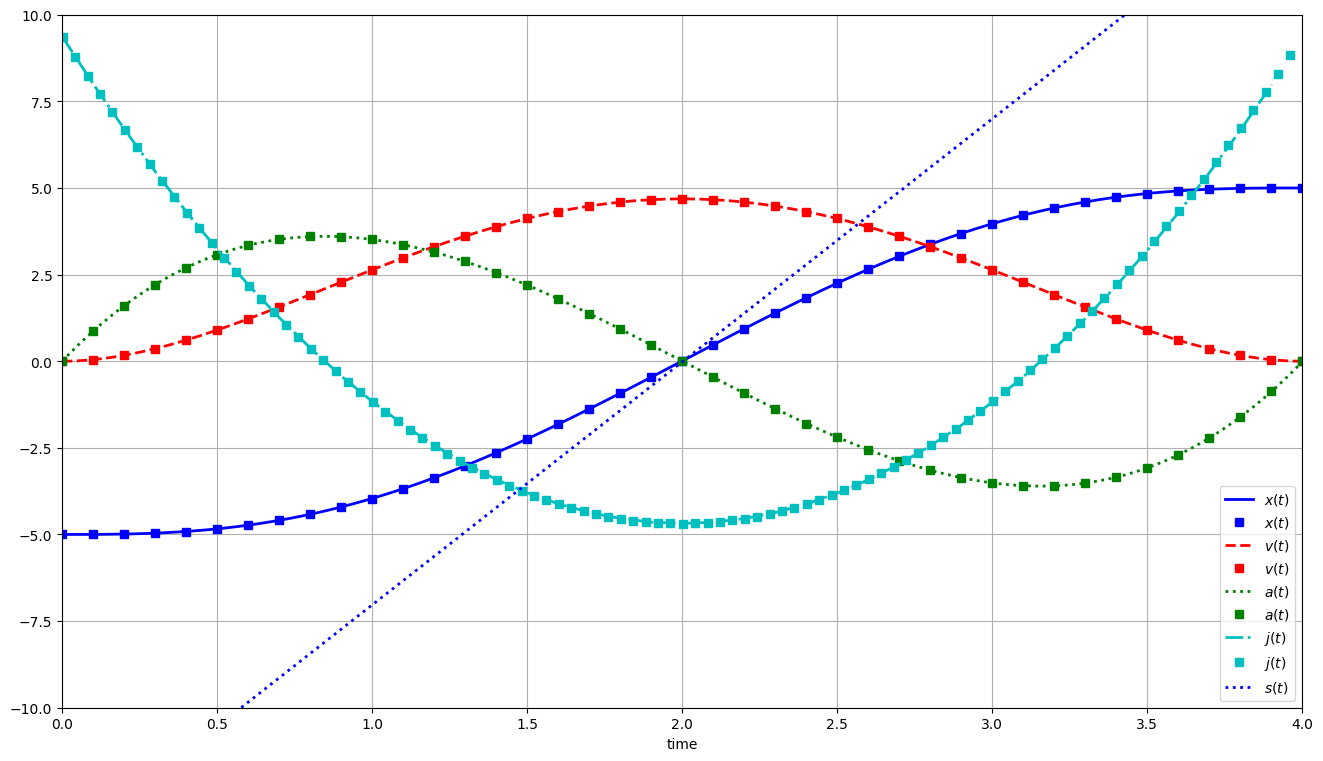

In [5]:
plt.figure(1,figsize=(16,9))
ax1 = plt.subplot(111)
ax1.grid(True)
ax1.plot(tt_4, p, 'b',label=r'$x(t)$')
ax1.plot(tt_4[0::50], numfun(tt_4[0::50],x0,xf,tf), 'bs',label=r'$x(t)$')
ax1.plot(tt_4, v, 'r--',label=r'$v(t)$')
ax1.plot(tt_4[0::50], numvfun(tt_4[0::50],x0,xf,tf), 'rs',label=r'$v(t)$')
ax1.plot(tt_4, a, 'g:',label=r'$a(t)$')
ax1.plot(tt_4[0::50], numafun(tt_4[0::50],x0,xf,tf), 'gs',label=r'$a(t)$')
ax1.plot(tt_4[1:-1:50], j[1:-1:50], 'c-.',label=r'$j(t)$')
ax1.plot(tt_4[1:-1:20], numjfun(tt_4[1:-1:20],x0,xf,tf), 'cs',label=r'$j(t)$')
ax1.plot(tt_4[2:-1:], s[2:-1:], 'b:',label=r'$s(t)$')
ax1.legend(loc='best')
ax1.set_xlabel('time')
ax1.set_xlim([0, tf])
ax1.set_ylim([-1*(abs(xf)+abs(x0)), 1*(abs(xf)+abs(x0))])
plt.show()

In [12]:
vmax = vfun.subs(st,stf/2)
vmax


15*(-x0 + xf)/(8*tf)

In [13]:
from sympy.solvers import solve
from sympy import simplify
t_j_zero = solve(jfun,st)

amax = afun.subs(st,t_j_zero[0])
simplify(amax)

10*sqrt(3)*(-x0 + xf)/(3*tf**2)

In [14]:
jmax = jfun.subs(st,0)
jmax

60*(-x0 + xf)/tf**3

In [15]:
simplify(amax/vmax)

16*sqrt(3)/(9*tf)

In [16]:
simplify(jmax/vmax)

32/tf**2